# Predicción de Riesgo de Evento Cardíaco con Señales de ECG Usando la Base de Datos PTB Diagnostic ECG.

El desafío seleccionado es predecir el riesgo de un evento cardíaco utilizando señales de ECG. Este desafío se centra en el análisis de datos electrocardiográficos (ECG) de la base de datos PTB Diagnostic ECG, donde se desarrollará un modelo predictivo para identificar el riesgo de eventos cardíacos en pacientes con historial de enfermedades cardíacas.

*El procesamiento de los datos es lento debido a la cantidad de datos a utilizar (1,7gb con 549 registros de 290 sujetos), por lo que se sugiere realizar este procesamiento de forma local. Mas información en https://research.google.com/colaboratory/local-runtimes.html*





Los datos fueron extraidos directamente de la pagina Physionet.org y subidas a una carpeta de google drive sin alterar su contenido.

Enlace original: https://physionet.org/content/ptbdb/1.0.0/

## Obtención de Datos



Aqui se realiza la importación de modulo de Google Collab que permite cargar archivos de Google Drive



Selección de ruta de la base de datos



In [117]:
folder_path = './ptb-diagnostic-ecg-database-1.0.0'                             # Ruta local




Aqui se utiliza el archivo RECORDS que contiene todas las referencias de los nombres de los pacientes como tambien de sus archivos asociados

In [118]:
ruta_records = folder_path + '/RECORDS'

# Leer el archivo 'records' para obtener la lista de archivos
with open(ruta_records, 'r') as f:
    registros = f.read().splitlines()

# Ver los registros cargados
print(registros)

['patient001/s0010_re', 'patient001/s0014lre', 'patient001/s0016lre', 'patient002/s0015lre', 'patient003/s0017lre', 'patient004/s0020are', 'patient004/s0020bre', 'patient005/s0021are', 'patient005/s0021bre', 'patient005/s0025lre', 'patient005/s0031lre', 'patient005/s0101lre', 'patient006/s0022lre', 'patient006/s0027lre', 'patient006/s0064lre', 'patient007/s0026lre', 'patient007/s0029lre', 'patient007/s0038lre', 'patient007/s0078lre', 'patient008/s0028lre', 'patient008/s0037lre', 'patient008/s0068lre', 'patient009/s0035_re', 'patient010/s0036lre', 'patient010/s0042lre', 'patient010/s0061lre', 'patient011/s0039lre', 'patient011/s0044lre', 'patient011/s0049lre', 'patient011/s0067lre', 'patient012/s0043lre', 'patient012/s0050lre', 'patient013/s0045lre', 'patient013/s0051lre', 'patient013/s0072lre', 'patient014/s0046lre', 'patient014/s0056lre', 'patient014/s0071lre', 'patient015/s0047lre', 'patient015/s0057lre', 'patient015/s0152lre', 'patient016/s0052lre', 'patient016/s0060lre', 'patient01

Instalación de librerías

In [119]:
%pip install wfdb
%pip install seaborn
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Carga de datos en una lista

In [120]:

import wfdb
import os

# Ruta base donde están las carpetas de los pacientes
ruta_base_datos = folder_path

# Lista para almacenar todos los registros cargados
todos_los_registros = []

# Iterar sobre los registros del archivo 'records'
for registro in registros:
    try:
        # Construir la ruta completa para el archivo
        record_path = os.path.join(ruta_base_datos, registro)

        # Cargar el archivo
        record = wfdb.rdrecord(record_path)

        # Agregar el registro cargado a la lista
        todos_los_registros.append(record)

        #print(f"Cargado: {record_path}")

    except Exception as e:
        print(f"Error cargando {record_path}: {e}")

print(f"Total de registros cargados: {len(todos_los_registros)}")

Total de registros cargados: 549


## Identificación de Pacientes STEMI y HC

La base de datos PTB Diagnostic ECG contiene un atributo llamado "comments" el cual contiene información relevante sobre el paciente, en este caso se busca identificar a los pacientes que han sufrido un infarto agudo de miocardio (STEMI) y los pacientes con control sanos (HC).

### Pacientes con Infarto Agudo de Miocardio con Elevación del Segmento ST (STEMI)

Aqui se listan los valores unicos del atributo 'Acute infarction (localization)' al interior del atributo "comments" y se cuenta su frecuencia.
En este caso el atributo 'Acute infarction (localization)' contiene la información de la localización del evento cardiaco, por lo tanto se realiza una busqueda en ese campo.



In [121]:
locations_frecuencia = {}

for record in todos_los_registros:
    location = record.comments[5].split(':')[1].strip()
    if location in locations_frecuencia:
        locations_frecuencia[location]['frec'] += 1
    else:
        locations_frecuencia[location] = {'nombre': location, 'frec': 1}

print('Frecuencia de cada valor único del atributo Acute infarction (localization):')
for location, data in locations_frecuencia.items():
    print(f"{data['nombre']}")

Frecuencia de cada valor único del atributo Acute infarction (localization):
infero-latera
anterior
infero-postero-lateral
antero-septal
inferior
infero-lateral
infero-poster-lateral
antero-lateral
lateral
postero-lateral
posterior
no
infero-posterior
n/a
antero-septo-lateral
unknown


Aqui se muestra un histograma de frecuencias de cada localización encontrada en el apartado 'Acute infarction (localization)' en el atributo 'comments' de la base de datos PTB Diagnostic ECG.

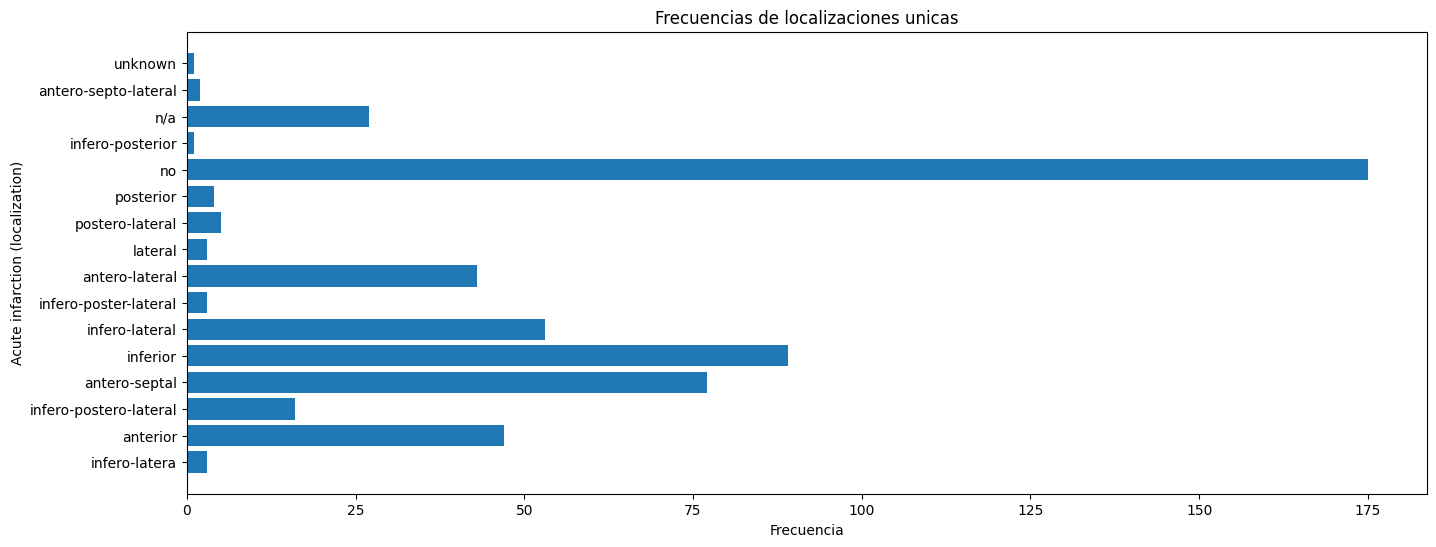

In [122]:
# Plot de frecuencias de localizaciones unicas
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
frequencies = [data['frec'] for data in locations_frecuencia.values()]

plt.title('Frecuencias de localizaciones unicas')
plt.barh(list(locations_frecuencia.keys()), frequencies)
plt.ylabel('Acute infarction (localization)')
plt.xlabel('Frecuencia')
plt.show()

 Filtrado de registros que tengan localización descrita en su atributo 'comments'

Aqui se hace un filtrado de los registros que contengan información relacionada a STEMI en su atribubo 'comments'. Para esto, se quitan los registros que contengan 'no','n/a' y 'unknown' en el apartado de 'Acute infarction (localization)'.

In [123]:
stemi_records = []
stemi_avoid_locations = ['no', 'n/a', 'unknown']

for record in todos_los_registros:
    reason = record.comments[4].split(':')[1].strip()
    localization1 = record.comments[5].split(':')[1].strip()

    # Agregar record a stemi_records si reason no esta en stemi_avoid_locations
    if reason == 'Myocardial infarction':
        if localization1 not in stemi_avoid_locations:
            stemi_records.append(record)

print("Total de stemi_records: ", len(stemi_records))

Total de stemi_records:  346


Aqui se hace nuevamente un recuento de los valores unicos filtrados en el atributo 'Acute infarction (localization)' en el atributo 'comments' de la base de datos PTB Diagnostic ECG .

In [124]:
locations_frecuencia_stemi = {}
for record in stemi_records:
    location = record.comments[5].split(':')[1].strip()
    if location in locations_frecuencia_stemi:
        locations_frecuencia_stemi[location]['frec'] += 1
    else:
        locations_frecuencia_stemi[location] = {'nombre': location, 'frec': 1}

Histograma de frecuencias de localizaciones STEMI

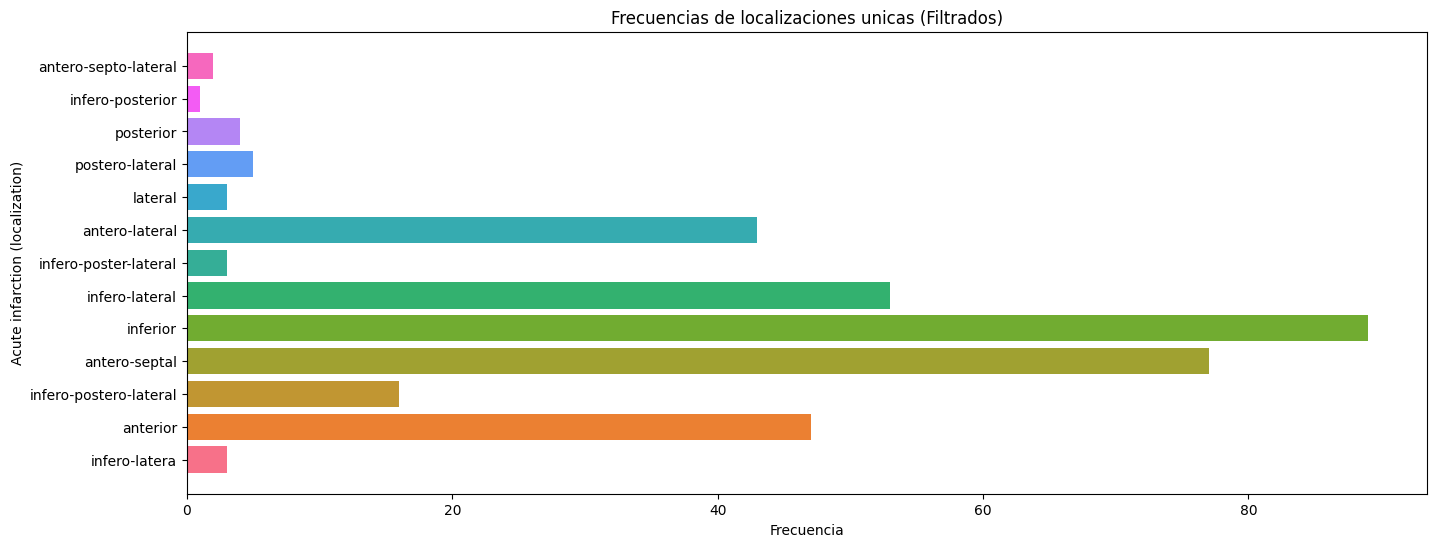

In [125]:
import seaborn as sns

# Plot de frecuencias de localizaciones unicas
import matplotlib.pyplot as plt

# Definir una paleta de colores
palette = sns.color_palette("husl", len(locations_frecuencia_stemi))

plt.figure(figsize=(16, 6))
stemi_frequencies = [data['frec'] for data in locations_frecuencia_stemi.values()]

plt.title('Frecuencias de localizaciones unicas (Filtrados)')
plt.barh(list(locations_frecuencia_stemi.keys()), stemi_frequencies, color=palette)
plt.ylabel('Acute infarction (localization)')
plt.xlabel('Frecuencia')
plt.show()

## Cargando nuevos datos de registros de pacientes sanos

### Pacientes Control Sanos (HC)

#### Obtención de datos de base de datos PTB-XL

Se decidió obtener nuevos registros de otra base de datos debido al desbalanceo de la base de datos PTB Diagnostic ECG. Para esto se utilizó la base de datos PTB-XL, la cual contiene registros de pacientes control sanos (HC).

Para esto, se debió realizar un proceso de filtrado de los registros de la base de datos PTB-XL, donde se seleccionaron los registros que no contenían información relacionada a enfermedades cardíacas.

Aqui se retornan los ids de los ecg de registros que contengan 'NORM' en el atributo 'scp_codes'. Solo se cargan los primeros 346 registros para el balanceo de clases con los datos STEMI

In [126]:
# cargar archivo ptbxl_database.csv

import pandas as pd

ruta_hc = './ptb-xl/ptb-xl/ptbxl_database.csv'

# Leer el archivo

hc_data = pd.read_csv(ruta_hc)

# extraer las filas en donde su atributo scp_codes contiene 'NORM'

hc_records = hc_data[hc_data['scp_codes'].str.contains('NORM')]['ecg_id'].head(346).astype(str).apply(lambda x: x.zfill(5) + '_hr')

# ver las filas seleccionadas

print('Total deHC_records: ', len(hc_records))

hc_records.head()

hc_records.tail()





Total deHC_records:  346


615    00628_hr
616    00629_hr
617    00630_hr
618    00631_hr
625    00638_hr
Name: ecg_id, dtype: object

Luego de identificar los ids de los ecg de registros sanos, se procede a cargar los datos en forma wfdb

In [127]:
import os
import wfdb
# Usando los indices hc_records para cargar los registros de los pacientes sanos

# Lista para almacenar todos los registros cargados
todos_los_registros_HC = []

for registro in hc_records:
    try:
        # Construir la ruta completa para el archivo
        record_path = os.path.join('./ptb-xl/ptb-xl/records500/00000/', registro)

        # Cargar el archivo
        record = wfdb.rdrecord(record_path)

        # Agregar el registro cargado a la lista
        todos_los_registros_HC.append(record)

        #print(f"Cargado: {record_path}")

    except Exception as e:
        print(f"Error cargando {record_path}: {e}")

print(f"Total de registros cargados: {len(todos_los_registros_HC)}")

Total de registros cargados: 346


In [128]:
print(todos_los_registros_HC[0].__dict__)

{'record_name': '00001_hr', 'n_sig': 12, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
       [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
       [-0.115, -0.05 ,  0.065, ..., -0.035, -0.035, -0.075],
       ...,
       [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
       [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ],
       [ 0.21 ,  0.205, -0.005, ...,  0.185,  0.17 ,  0.18 ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat', '00001_hr.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16'], 

Una de las principales diferencias con los registros STEMI es la frecuencia de muestreo de esa nueva base de datos, los cuales los registros estan a 500hz

### Comparación de registros STEMI y HC

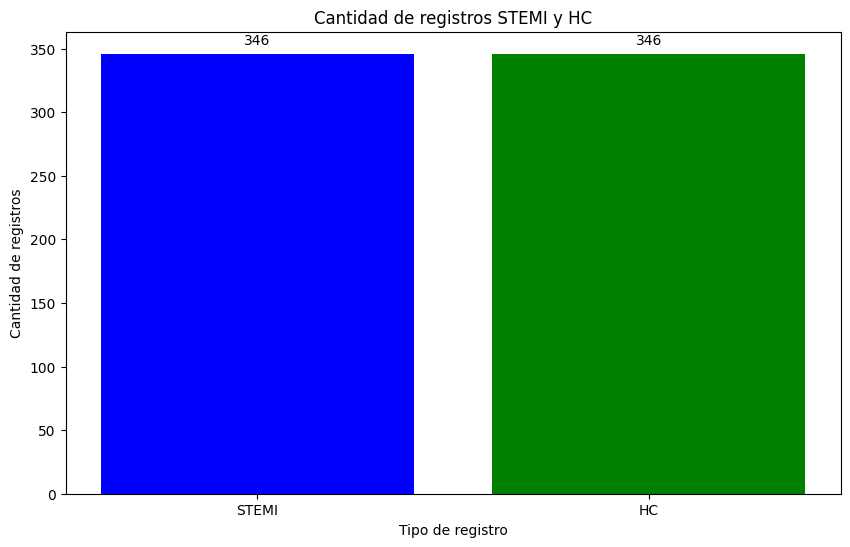

In [129]:
# Histograma de cantidad de registros STEMI de la viable stemi_records y HC_records
plt.figure(figsize=(10, 6))
bars = plt.bar(['STEMI', 'HC'], [len(stemi_records), len(hc_records)], color=['blue', 'green'])
plt.title('Cantidad de registros STEMI y HC')
plt.xlabel('Tipo de registro')
plt.ylabel('Cantidad de registros')

# Agregar números encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()


### Liberación de Memoria

Luego de obtener estos 2 sets de registros, se procede a liberar la memoria de los registros que no se utilizarán en el análisis.

In [130]:
todos_los_registros.clear()

## Preprocesamiento de Señales ECG

Para el procesamiento de las señales ECG se realizaran las siguientes tareas:
- **Eliminación de canales de posicion de electrodos** identificando los nombres Vx, Vy y Vz.
- **Downsampling de canales** de registros STEMI de 1000 a 500 Hz. 
- **Filtrado de ruido** mediante un filtro pasa banda Butterworth de 0.67 a 30 Hz.

### Eliminación de canales de posición de electrodos

Los registros STEMI contienen información de la posición de los electrodos por lo tanto se procede a eliminar estos canales de los registros debido a que no aportan información relevante para el análisis.

In [131]:
# Eliminar los canales vx, vy y vz
for record in stemi_records:
    record.sig_name = record.sig_name[:12]
    record.p_signal = record.p_signal[:, :12]

print(stemi_records[0].sig_name)
print(stemi_records[0].p_signal)
print(len(stemi_records[0].p_signal))


['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
[[-0.2445 -0.229   0.0155 ...  0.106   0.1965  0.195 ]
 [-0.2425 -0.2335  0.009  ...  0.1095  0.202   0.198 ]
 [-0.2415 -0.2345  0.007  ...  0.1095  0.2005  0.1965]
 ...
 [ 0.152   0.2695  0.118  ... -0.0775 -0.1205 -0.1615]
 [ 0.136   0.256   0.1205 ... -0.081  -0.1245 -0.1645]
 [ 0.135   0.2585  0.1245 ... -0.084  -0.1245 -0.1665]]
38400


### Downsampling de registros STEMI

Se realiza un downsampling de los registros STEMI de 1000 a 500 Hz para que coincida con la frecuencia de muestreo de los registros HC.

In [132]:
from scipy.signal import resample
# Downsample de señales de los registros stemi_records de 1000hz a 500 Hz

for record in stemi_records:
    signal = record.p_signal  # Obtiene la señal
    new_length = signal.shape[0] // 2
    record.p_signal = resample(signal, new_length)







### Filtrado de ruido en señales ECG

Se realiza un filtrado de ruido en las señales ECG mediante un filtro pasa banda Butterworth de 0.67 a 30 Hz a los registros STEMI.
A los registros HC no se les aplica este filtro debido a que ya se encuentran filtrados en la base de datos PTB-XL.

importar librerias

In [133]:
import numpy as np
from scipy.signal import butter, filtfilt


Creación de función de filtro butterworth

In [134]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [135]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


Uso del filtro butterworth en las señales ECG de registros STEMI

In [136]:
import copy

# Parámetros del filtro
lowcut = 0.67  # Frecuencia mínima (Hz)
highcut = 30.0  # Frecuencia máxima (Hz)
fs = 1000  # Frecuencia de muestreo (Hz), 1 kHz para la base de datos PTB

num_channels= 12

# Obtener una señal raw para comparar mas adelante
canal_a_comparar = 0  # Índice del canal (ejemplo: 0 para el primer canal, i.e., Lead I)
raw_signal = copy.deepcopy(stemi_records[0].p_signal[:, canal_a_comparar])


for record in stemi_records:
    
    for i in range(num_channels):
        # Aplicar el filtro Butterworth a cada canal
        filtered_signal = butter_bandpass_filter(record.p_signal[:, i], lowcut, highcut, fs, order=3)
        
        # Sobrescribir la señal filtrada en el registro
        record.p_signal[:, i] = filtered_signal





### Graficado de señales ECG filtradas

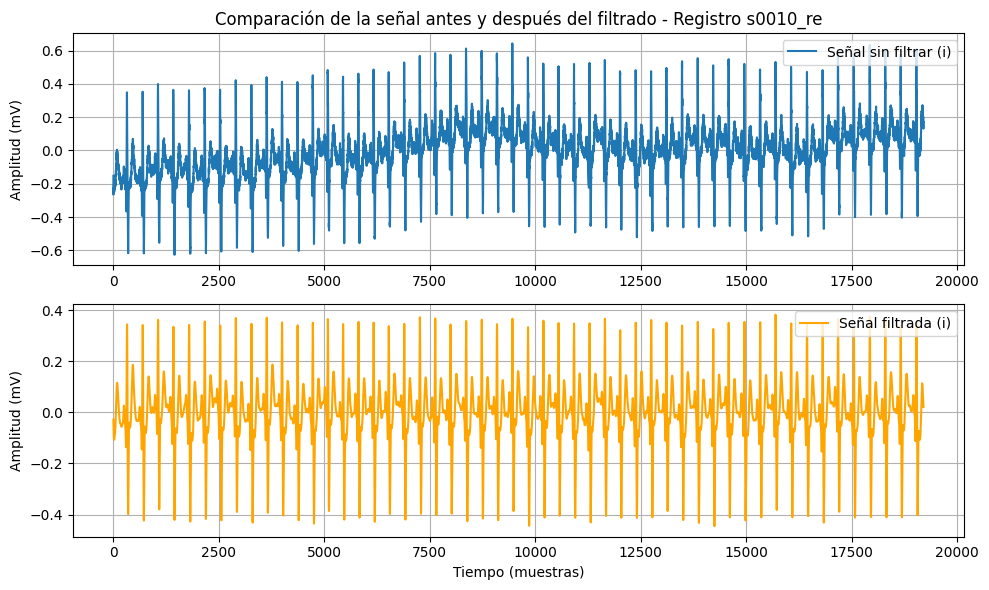

In [137]:
import matplotlib.pyplot as plt
# Selección del registro y canal a comparar

# Aplicar el filtro Butterworth a la señal
filtered_signal = stemi_records[0]

# Graficar señal antes y después del filtrado
plt.figure(figsize=(10, 6))

# Señal sin filtrar
plt.subplot(2, 1, 1)
plt.plot(raw_signal, label=f'Señal sin filtrar ({filtered_signal.sig_name[canal_a_comparar]})')
plt.title(f'Comparación de la señal antes y después del filtrado - Registro {filtered_signal.record_name}')
plt.ylabel('Amplitud (mV)')
plt.legend(loc='upper right')
plt.grid(True)

# Señal filtrada
plt.subplot(2, 1, 2)
plt.plot(filtered_signal.p_signal[:, canal_a_comparar], label=f'Señal filtrada ({filtered_signal.sig_name[canal_a_comparar]})', color='orange')
plt.ylabel('Amplitud (mV)')
plt.xlabel('Tiempo (muestras)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

### Comparación de señaes ECG de registros STEMI y HC

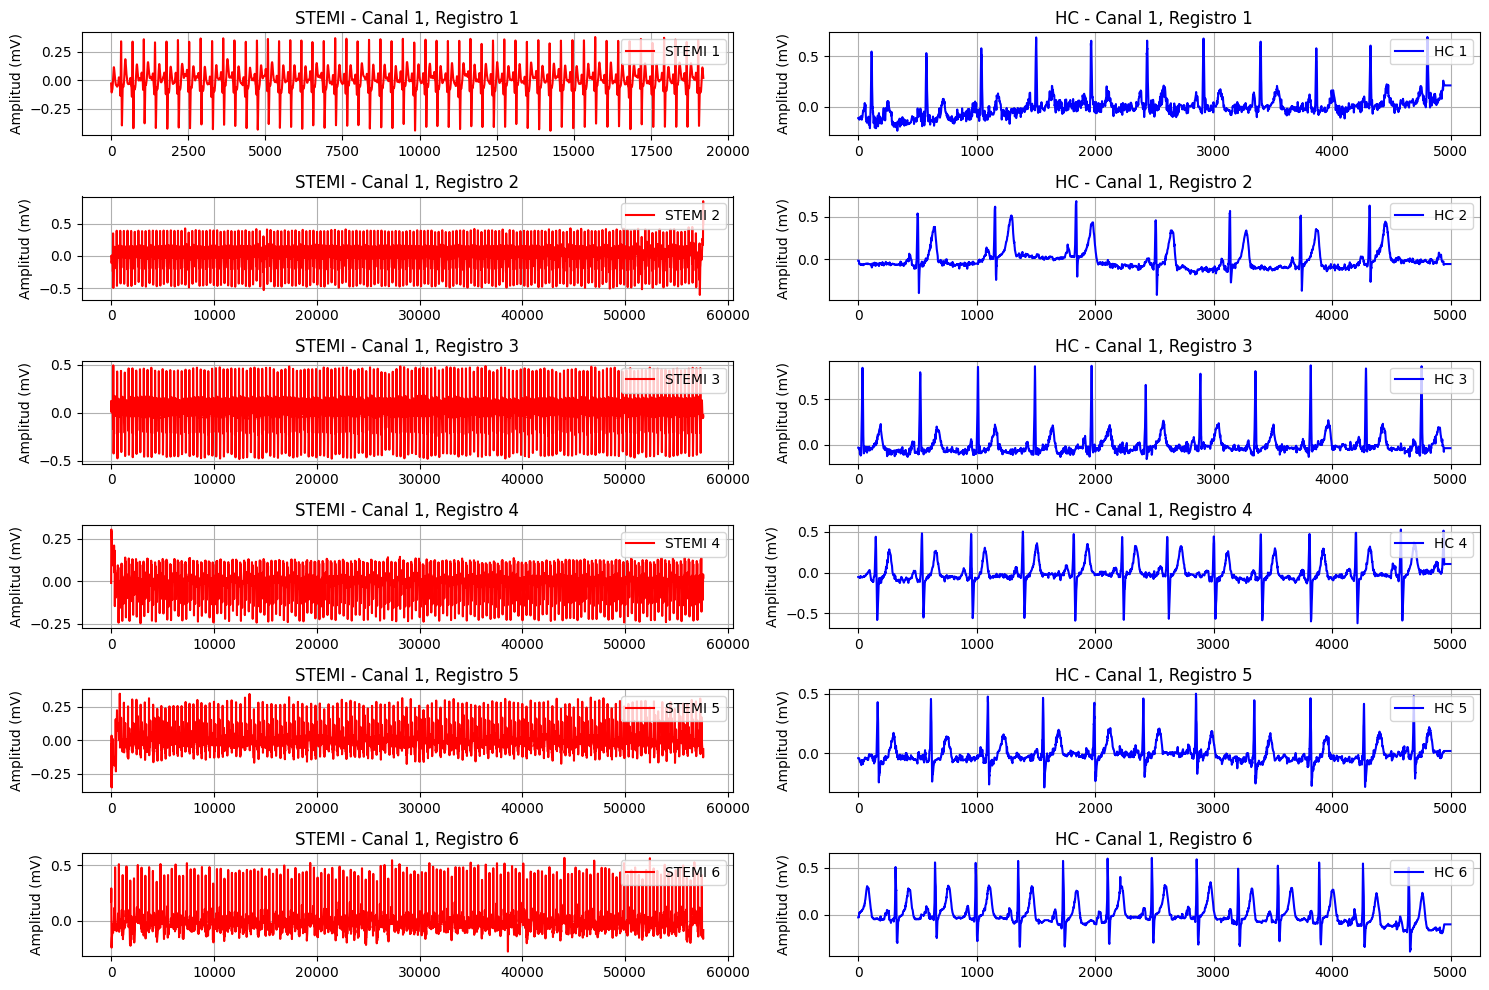

In [138]:

# Comparar señales de stemi_records y hc_records

# Selección de un canal y los primeros 5 registros a comparar
canal_a_comparar = 0  

# Graficar señales de los pacientes
plt.figure(figsize=(15, 10))

for i in range(6):
    stemi_signal = stemi_records[i].p_signal[:, canal_a_comparar]
    hc_signal = todos_los_registros_HC[i].p_signal[:, canal_a_comparar]

    plt.subplot(6, 2, 2*i + 1)
    plt.plot(stemi_signal, label=f'STEMI {i+1}', color='red')
    plt.title(f'STEMI - Canal {canal_a_comparar + 1}, Registro {i + 1}')
    plt.ylabel('Amplitud (mV)')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(6, 2, 2*i + 2)
    plt.plot(hc_signal, label=f'HC {i+1}', color='blue')
    plt.title(f'HC - Canal {canal_a_comparar + 1}, Registro {i + 1}')
    plt.ylabel('Amplitud (mV)')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Random Forest

In [139]:
import numpy as np

# Función para extraer características básicas
def extract_features(signal):
    features = {}
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    return features

# Extraer características para cada derivación del ECG
ecg_features = []
for record in stemi_records:  # Iterar sobre cada registro
    for lead_signal in record.p_signal.T:  # Iterar sobre cada derivación
        ecg_features.append(extract_features(lead_signal))

print(len(ecg_features))

for record in todos_los_registros_HC:  # Iterar sobre cada registro
    for lead_signal in record.p_signal.T:  # Iterar sobre cada derivación
        ecg_features.append(extract_features(lead_signal))

print(len(ecg_features))

# Convirtiendo a dataframe
import pandas as pd
ecg_features_df = pd.DataFrame(ecg_features)


4152
8304


In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Creando labels, 1 para STEMI y 0 para HC

labels = []
for e in range(0,4151):
    labels.append(1)

for e in range(4151, 8304):
    labels.append(0)


# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(ecg_features_df, labels, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
print("Precisión:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))


Precisión: 0.872366044551475
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       835
           1       0.86      0.89      0.87       826

    accuracy                           0.87      1661
   macro avg       0.87      0.87      0.87      1661
weighted avg       0.87      0.87      0.87      1661



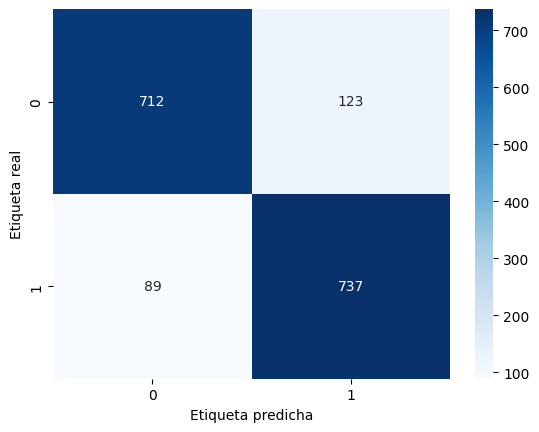

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.show()


## Exportación de modelo

In [116]:
import joblib

joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']